In [57]:
import os
import numpy as np
import pandas as pd
import tqdm
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from typing import Sequence
from xgboost import XGBClassifier


## 全局变量

In [58]:
COMPANY = 101410010  # @param { isTemplate: true, type: 'string'}
LOSS = 'bce'  # @param { isTemplate: true, type: 'string'} ['bce', 'ziln']
MODEL = 'dnn'  # @param { isTemplate: true, type: 'string'} ['linear', 'dnn','xgboost']
LEARNING_RATE = 0.0002  # @param { isTemplate: true}
EPOCHS = 400  # @param {type: 'integer'}
OUTPUT_CSV_FOLDER = r'D:\github_repo_forked\lifetime_value\result'  # @param { isTemplate: true, type: 'string'}

In [59]:
CATEGORICAL_FEATURES = ['chain', 'dept', 'category', 'brand', 'productmeasure']
NUMERIC_FEATURES = ['log_calibration_value']

ALL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

### 加载预处理后的custom数据集


In [60]:
def load_customer_level_csv(company):
  customer_level_data_file = (
      r'D:\github_repo_forked\lifetime_value\acquire-valued-shoppers-challenge\customer_level_data_company_{}.csv'
      .format(company))
  if os.path.isfile(customer_level_data_file):
    customer_level_data = pd.read_csv(customer_level_data_file)
  else:
    print('请先使用preprocess.py进行预处理')
    return
  for cat_col in CATEGORICAL_FEATURES:
    customer_level_data[cat_col] = (
        customer_level_data[cat_col].astype('category'))
  for num_col in [
      'log_calibration_value', 'calibration_value', 'holdout_value'
  ]:
    customer_level_data[num_col] = (
        customer_level_data[num_col].astype('float32'))

  return customer_level_data

In [61]:
customer_level_data = load_customer_level_csv(COMPANY)

<Axes: >

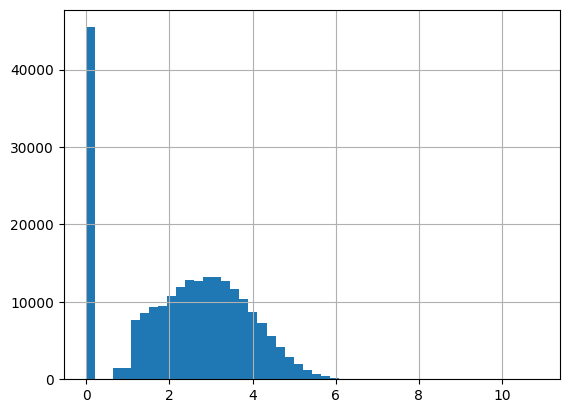

In [62]:
customer_level_data.label.apply(np.log1p).hist(bins=50)

<Axes: >

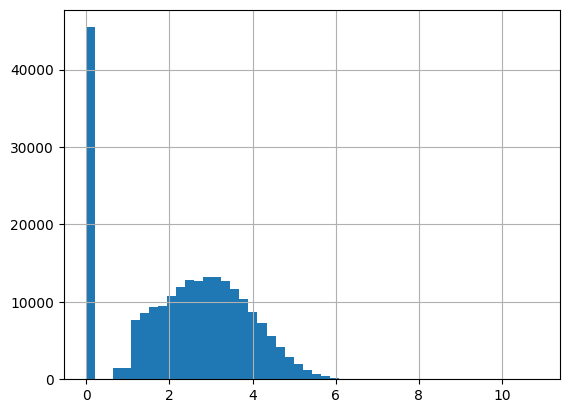

In [63]:
customer_level_data.label.apply(np.log1p).hist(bins=50)

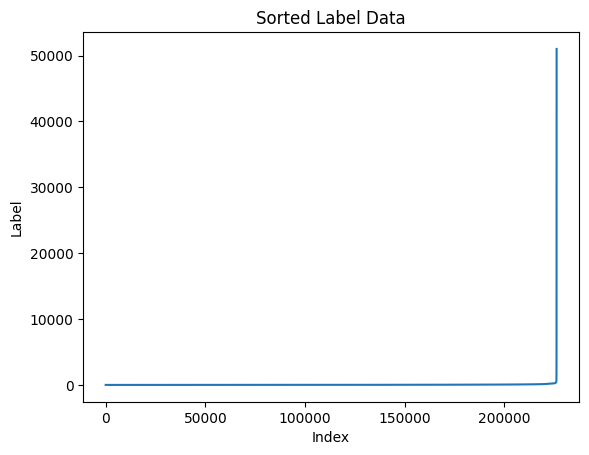

In [64]:
import matplotlib.pyplot as plt

# 假设 customer_level_data 是一个 Pandas DataFrame
sorted_data = customer_level_data.sort_values(by='label')  # 按照 label 列排序

x = range(len(sorted_data))  # x轴数据，这里使用数据的索引
y = sorted_data.label  # y轴数据，即排序后的 label 列

# 绘制折线图
plt.plot(x, y)

# 添加标题和坐标轴标签
plt.title('Sorted Label Data')
plt.xlabel('Index')
plt.ylabel('Label')

# 显示图形
plt.show()



In [65]:
customer_level_data.head().T

,0,1,2,3,4
id,86246,86252,12262064,12277270,12332190
calibration_value,3.99,4.49,3.39,2.99,1.99
chain,205,205,95,95,95
dept,9,9,9,9,9
category,907,912,905,910,902
brand,13791,13791,13791,13791,45039
productmeasure,OZ,OZ,OZ,OZ,OZ
holdout_value,83.080002,179.410004,6.98,6.79,0.0
log_calibration_value,1.383791,1.501853,1.22083,1.095273,0.688135
label,83.08,179.41,6.98,6.79,0.0


In [66]:
customer_level_data.dtypes

id                          int64
calibration_value         float32
chain                    category
dept                     category
category                 category
brand                    category
productmeasure           category
holdout_value             float32
log_calibration_value     float32
label                     float64
dtype: object

In [67]:
pd.get_dummies(customer_level_data, columns=ALL_FEATURES).astype('float32').head().T

,0,1,2,3,4
id,86246.000000,86252.000000,12262064.00,12277270.00,12332190.00
calibration_value,3.990000,4.490000,3.39,2.99,1.99
holdout_value,83.080002,179.410004,6.98,6.79,0.00
label,83.080002,179.410004,6.98,6.79,0.00
chain_2,0.000000,0.000000,0.00,0.00,0.00
...,...,...,...,...,...
log_calibration_value_4.596532821655273,0.000000,0.000000,0.00,0.00,0.00
log_calibration_value_4.613237380981445,0.000000,0.000000,0.00,0.00,0.00
log_calibration_value_4.691714763641357,0.000000,0.000000,0.00,0.00,0.00
log_calibration_value_4.791234493255615,0.000000,0.000000,0.00,0.00,0.00


In [68]:
customer_level_data['label'].unique()
num_zeros = customer_level_data['label'].value_counts().get(0, 0)
print(f"Number of 0s in label: {num_zeros}")

Number of 0s in label: 45441


In [69]:
x = pd.get_dummies(customer_level_data[ALL_FEATURES], drop_first=True).astype('float32').values
y = np.where(customer_level_data['label'].values > 0, 1, 0)
print(sum(y) / len(y))

x_train, x_eval, y_train, y_eval = model_selection.train_test_split(
    x, y, test_size=0.2, random_state=123,stratify=y)
print(sum(y_train) / len(y_train), sum(y_eval) / len(y_eval))

0.7991957400737975


0.7991946353211516 0.799200159084381


### 数据集划分

In [70]:
def linear_split(df):
  # get_dummies preserves numeric features.
  x = pd.get_dummies(df[ALL_FEATURES], drop_first=True).astype('float32').values
  y = df['label'].values

  x_train, x_eval, y_train, y_eval = model_selection.train_test_split(
      x, y, test_size=0.2, random_state=123)

  return x_train, x_eval, y_train, y_eval

In [71]:
def xgboost_split(df):
    x = pd.get_dummies(df[ALL_FEATURES], drop_first=True).astype('float32').values
    y = np.where(df['label'].values > 0, 1, 0)

    x_train, x_eval, y_train, y_eval = model_selection.train_test_split(
        x, y, test_size=0.2, random_state=123,stratify=y)

    return x_train, x_eval, y_train, y_eval

In [72]:
def dnn_split(df):
  for key in CATEGORICAL_FEATURES:
    encoder = preprocessing.LabelEncoder()
    df[key] = encoder.fit_transform(df[key])

  df_train, df_eval = model_selection.train_test_split(
      df, test_size=0.2, random_state=123)

  def feature_dict(df):
    features = {k: torch.tensor(v.values) for k, v in dict(df[CATEGORICAL_FEATURES]).items()}
    features['numeric'] = torch.tensor(df[NUMERIC_FEATURES].values)
    return features

  x_train, y_train = feature_dict(df_train), df_train['label'].values
  x_eval, y_eval = feature_dict(df_eval), df_eval['label'].values
  return x_train, x_eval, y_train, y_eval

### Model

In [73]:
import torch.nn as nn

def linear_model(input_dim, output_units):
    return nn.Linear(input_dim, output_units)


In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def embedding_dim(x):
    return int(x**0.25) + 1

class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size):
        super(EmbeddingLayer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim(vocab_size))
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.embedding(x)
        x = self.flatten(x)
        return x

class DNNModel(nn.Module):
    def __init__(self, output_units, df):
        super(DNNModel, self).__init__()
        self.numeric_input = nn.Linear(len(NUMERIC_FEATURES), 64)
        self.embedding_layers = nn.ModuleList([
            EmbeddingLayer(df[key].nunique()) for key in CATEGORICAL_FEATURES
        ])
        # 计算每个嵌入层的维度
        embedding_dims = [embedding_dim(df[feature].nunique()) for feature in CATEGORICAL_FEATURES]
        # 计算总的嵌入维度
        total_embedding_dim = sum(embedding_dims)
        # 第一个线性层的输入维度
        input_dim = 64 + total_embedding_dim
        self.deep_model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_units)
        )

    def forward(self, numeric_input, *embedding_inputs):
        numeric_output = F.relu(self.numeric_input(numeric_input))
        embedding_outputs = [layer(input) for layer, input in zip(self.embedding_layers, embedding_inputs)]
        deep_input = torch.cat([numeric_output] + embedding_outputs, dim=1)
        output = self.deep_model(deep_input)
        return output


In [75]:
def xgboost_model():
    return XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='aucpr',
        n_estimators=1000,
        n_jobs=-1,
        verbosity=1,
        random_state=123,
        early_stopping_round=10
    )

### Train

In [76]:
import torch.nn as nn
import sys
sys.path.append(r'D:\github_repo_forked\lifetime_value')
from lifetime_value_pytorch.zero_inflated_lognormal import zero_inflated_lognormal_loss
if LOSS == 'bce':
    loss_fn = nn.BCEWithLogitsLoss()
    output_units = 1

if LOSS == 'ziln':
    loss_fn = zero_inflated_lognormal_loss
    output_units = 3


In [77]:
if MODEL == 'linear':
  x_train, x_eval, y_train, y_eval = linear_split(customer_level_data)
  input_dimension = x_train.shape[1]
  print(input_dimension)
  model = linear_model(input_dimension,output_units)

if MODEL == 'dnn':
  x_train, x_eval, y_train, y_eval = dnn_split(customer_level_data)
  model = DNNModel(output_units, customer_level_data)
  print(model)

if MODEL == 'xgboost':
  x_train, x_eval, y_train, y_eval = xgboost_split(customer_level_data)
  model = xgboost_model()

143


In [78]:
if MODEL == 'xgboost':
    model.fit(x_train, 
              y_train,
              verbose=True,
              eval_set=[(x_eval, y_eval)],
              )

In [79]:
if LOSS == 'bce':
  y_train = (y_train > 0).astype('float32')
  y_eval = (y_eval > 0).astype('float32')

Epoch 1/400, Train Loss: 0.7326, Val Loss: 0.7091
Epoch 2/400, Train Loss: 0.6880, Val Loss: 0.6678
Epoch 3/400, Train Loss: 0.6504, Val Loss: 0.6332
Epoch 4/400, Train Loss: 0.6191, Val Loss: 0.6044
Epoch 5/400, Train Loss: 0.5931, Val Loss: 0.5805
Epoch 6/400, Train Loss: 0.5716, Val Loss: 0.5609
Epoch 7/400, Train Loss: 0.5540, Val Loss: 0.5448
Epoch 8/400, Train Loss: 0.5397, Val Loss: 0.5317
Epoch 9/400, Train Loss: 0.5280, Val Loss: 0.5210
Epoch 10/400, Train Loss: 0.5186, Val Loss: 0.5124
Epoch 11/400, Train Loss: 0.5110, Val Loss: 0.5055
Epoch 12/400, Train Loss: 0.5049, Val Loss: 0.4999
Epoch 13/400, Train Loss: 0.4999, Val Loss: 0.4953
Epoch 14/400, Train Loss: 0.4960, Val Loss: 0.4917
Epoch 15/400, Train Loss: 0.4928, Val Loss: 0.4888
Epoch 16/400, Train Loss: 0.4902, Val Loss: 0.4864
Epoch 17/400, Train Loss: 0.4881, Val Loss: 0.4845
Epoch 18/400, Train Loss: 0.4863, Val Loss: 0.4828
Epoch 19/400, Train Loss: 0.4849, Val Loss: 0.4815
Epoch 20/400, Train Loss: 0.4837, Val Lo

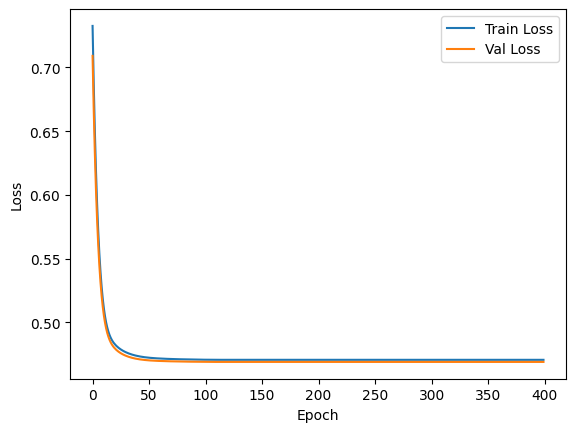

In [80]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 假设你已经定义了模型、损失函数和优化器
criterion = loss_fn
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# 创建数据加载器
if MODEL == 'linear':
    train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
    eval_dataset = TensorDataset(torch.Tensor(x_eval), torch.Tensor(y_eval))

if MODEL == 'dnn':
    train_dataset = TensorDataset(x_train['numeric'], *[x_train[key] for key in CATEGORICAL_FEATURES], torch.Tensor(y_train))
    eval_dataset = TensorDataset(x_eval['numeric'], *[x_eval[key] for key in CATEGORICAL_FEATURES], torch.Tensor(y_eval))
# 检查 train_dataset 和 eval_dataset 是否已定义
if train_dataset is None or eval_dataset is None:
    raise ValueError("train_dataset or eval_dataset is not defined. Please check the value of 'model'.")
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=1024, shuffle=False)

# 初始化变量
best_val_loss = float('inf')
patience = 10
no_improvement_count = 0
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

# 训练循环
train_losses = []
val_losses = []
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    if MODEL == 'linear':
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.unsqueeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

    if MODEL == 'dnn':
        for numeric_input, *categorical_inputs, labels in train_loader:
            numeric_input, labels = numeric_input.to(device), labels.to(device)
            categorical_inputs = [input.to(device) for input in categorical_inputs]
            optimizer.zero_grad()
            outputs = model(numeric_input, *categorical_inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * numeric_input.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        if MODEL == 'linear':
            for inputs, labels in eval_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                labels = labels.unsqueeze(1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        if MODEL == 'dnn':
            for numeric_input, *categorical_inputs, labels in eval_loader:
                numeric_input, labels = numeric_input.to(device), labels.to(device)
                categorical_inputs = [input.to(device) for input in categorical_inputs]
                outputs = model(numeric_input, *categorical_inputs)
                loss = criterion(outputs, labels.unsqueeze(1))
                val_loss += loss.item() * numeric_input.size(0)
                # 打印调试信息
                # print(f"Labels: {labels}")
                # print(f"Outputs: {outputs}")
                # print(f"Loss: {loss.item()}")
        val_loss /= len(eval_loader.dataset)
        val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 更新学习率
    lr_scheduler.step(val_loss)

    # 早停
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# 绘制损失曲线
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Eval


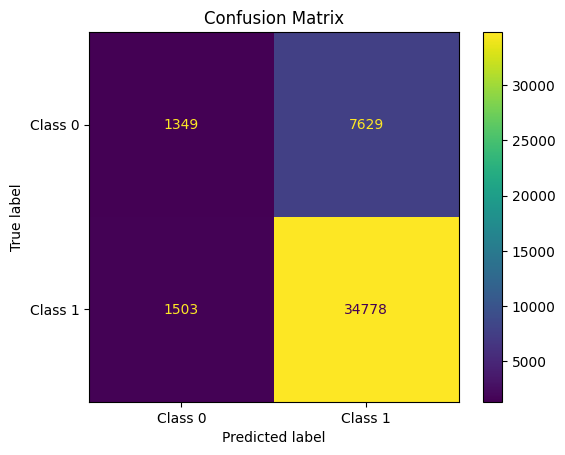

Confusion Matrix Analysis:
True Negatives (TN): 1349
False Positives (FP): 7629
False Negatives (FN): 1503
True Positives (TP): 34778

Key Metrics:
Accuracy: 0.7982
Precision: 0.8201
Recall: 0.9586
F1-score: 0.8839


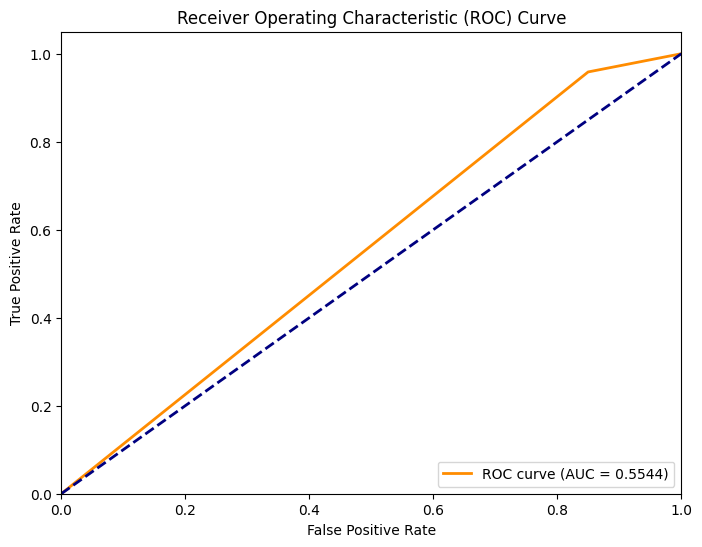

In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def analyze_confusion_matrix(y_true, y_pred):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                display_labels=['Class 0', 'Class 1'])
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()
    print("Confusion Matrix Analysis:")
    print(f"True Negatives (TN): {tn}")  # 正确预测为负类
    print(f"False Positives (FP): {fp}") # 错误预测为正类
    print(f"False Negatives (FN): {fn}") # 错误预测为负类
    print(f"True Positives (TP): {tp}")  # 正确预测为正类
    print("\nKey Metrics:")
    print(f"Accuracy: {accuracy:.4f}")   # 整体准确率
    print(f"Precision: {precision:.4f}") # 正类预测准确率
    print(f"Recall: {recall:.4f}")      # 正类预测召回率
    print(f"F1-score: {f1:.4f}")        # precision和recall的调和平均
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_auc(y_true, y_pred_proba):
    # Get predicted probabilities for positive class
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc
if MODEL == 'xgboost':
    # Get predictions
    y_pred = model.predict(x_eval)
    analyze_confusion_matrix(y_eval, y_pred)
    plot_roc_auc(y_eval,y_pred)
if MODEL == 'linear':
    # Get predictions
    y_pred = model(torch.Tensor(x_eval).to(device)).detach().cpu().numpy()
    y_pred = np.where(y_pred > 0.5, 1, 0)
    analyze_confusion_matrix(y_eval, y_pred)
    plot_roc_auc(y_eval,y_pred)



In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1, 10],
    'scale_pos_weight': [1, 3, 5]
}
optimal_params = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic',
                            seed=42,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            early_stopping_rounds=10,
                            eval_metric='auc',
                            device='cuda'

),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs=10,
    cv=3
)
optimal_params.fit(x_train,
                   y_train,
                   eval_set=[(x_eval, y_eval)],
                   verbose=False)
print(optimal_params.best_params_)          

{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 0, 'scale_pos_weight': 1}


In [28]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [7, 9, 11],
    'learning_rate': [0.1, 0.15, 0.2],
    'reg_lambda': [0, 1, 10],
    'scale_pos_weight': [1, 3, 5]
}
optimal_params = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic',
                            seed=42,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            early_stopping_rounds=10,
                            eval_metric='auc',
                            device='cuda'

),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs=10,
    cv=3
)
optimal_params.fit(x_train,
                   y_train,
                   eval_set=[(x_eval, y_eval)],
                   verbose=False)
print(optimal_params.best_params_)   

{'learning_rate': 0.2, 'max_depth': 11, 'reg_lambda': 1, 'scale_pos_weight': 3}


In [29]:
optimal_params.best_params_['gamma']

KeyError: 'gamma'

[0]	validation_0-aucpr:0.87776
[1]	validation_0-aucpr:0.87986
[2]	validation_0-aucpr:0.88259
[3]	validation_0-aucpr:0.88355
[4]	validation_0-aucpr:0.88464
[5]	validation_0-aucpr:0.88480
[6]	validation_0-aucpr:0.88498
[7]	validation_0-aucpr:0.88515
[8]	validation_0-aucpr:0.88523
[9]	validation_0-aucpr:0.88532
[10]	validation_0-aucpr:0.88604
[11]	validation_0-aucpr:0.88687
[12]	validation_0-aucpr:0.88714
[13]	validation_0-aucpr:0.88720
[14]	validation_0-aucpr:0.88736
[15]	validation_0-aucpr:0.88752
[16]	validation_0-aucpr:0.88776
[17]	validation_0-aucpr:0.88789
[18]	validation_0-aucpr:0.88805
[19]	validation_0-aucpr:0.88804
[20]	validation_0-aucpr:0.88818
[21]	validation_0-aucpr:0.88827
[22]	validation_0-aucpr:0.88868
[23]	validation_0-aucpr:0.88883
[24]	validation_0-aucpr:0.88900
[25]	validation_0-aucpr:0.88906
[26]	validation_0-aucpr:0.88909
[27]	validation_0-aucpr:0.88898
[28]	validation_0-aucpr:0.88907
[29]	validation_0-aucpr:0.88919
[30]	validation_0-aucpr:0.88924
[31]	validation_0-

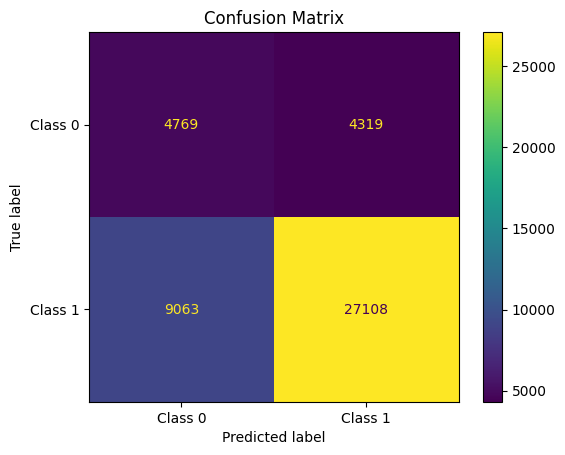

Confusion Matrix Analysis:
True Negatives (TN): 4769
False Positives (FP): 4319
False Negatives (FN): 9063
True Positives (TP): 27108

Key Metrics:
Accuracy: 0.7043
Precision: 0.8626
Recall: 0.7494
F1-score: 0.8020


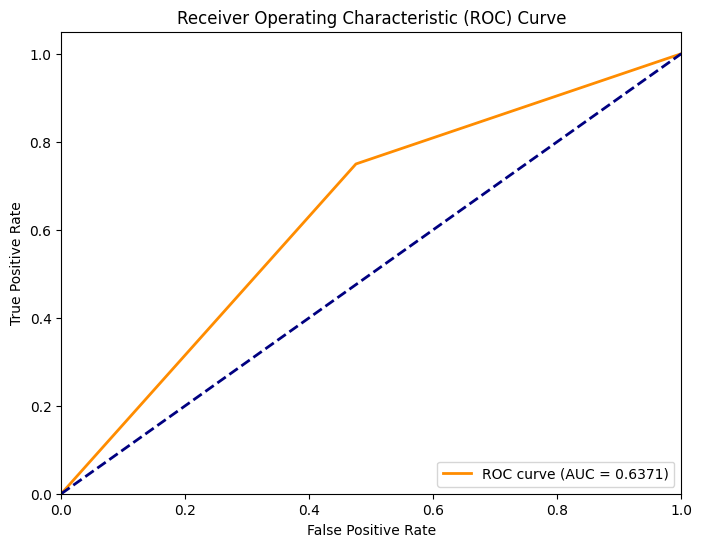

np.float64(0.6370990408894021)

In [56]:
optimal_xgb = XGBClassifier(
    max_depth=optimal_params.best_params_['max_depth'],
    learning_rate=optimal_params.best_params_['learning_rate'],
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.25,
    reg_lambda=optimal_params.best_params_['reg_lambda'],
    # min_child_weight = 5,  # 增加最小子节点权重
    objective='binary:logistic',
    scale_pos_weight=0.3,
    seed=42,
    eval_metric='aucpr',
    early_stopping_rounds=10
)
optimal_xgb.fit(x_train, y_train, verbose=True,  eval_set=[(x_eval, y_eval)])
y_pred = optimal_xgb.predict(x_eval)
analyze_confusion_matrix(y_eval, y_pred)
plot_roc_auc(y_eval, y_pred)


In [35]:
scale_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
print(scale_weight)

0.25125965040813364


In [29]:
model.eval()  # 将模型设置为评估模式

if MODEL == 'linear':
    x_eval = torch.Tensor(x_eval)  # 将numpy数组转换为PyTorch张量
    logits = model(x_eval)  # 前向传播
    y_pred = torch.sigmoid(logits[..., :1]).numpy().flatten()  # 应用sigmoid函数并转换为numpy数组

if MODEL == 'dnn':
    y_pred = []
    # eval_dataset = TensorDataset(x_eval['numeric'], *[x_eval[key] for key in CATEGORICAL_FEATURES], torch.Tensor(y_eval))
    # eval_loader = DataLoader(eval_dataset, batch_size=1024, shuffle=False)

    with torch.no_grad():  # 不需要计算梯度
        for numeric_input, *categorical_inputs, _ in eval_loader:
            numeric_input = numeric_input.to(device)
            categorical_inputs = [input.to(device) for input in categorical_inputs]
            logits = model(numeric_input, *categorical_inputs)
            y_pred.append(torch.sigmoid(logits[..., :1]).cpu().numpy())
    y_pred = np.concatenate(y_pred).flatten()


In [34]:
y_pred

array([0.82053465, 0.8229092 , 0.55011576, ..., 0.5729575 , 0.77717656,
       0.36958662], shape=(45259,), dtype=float32)

In [35]:
y_true = (y_eval > 0).astype('float32')

In [36]:
def classification_report(y_true: Sequence[int],
                          y_pred: Sequence[float]) -> pd.DataFrame:
  """Report individual level classification metrics.

  Arguments:
    y_true: true binary labels.
    y_pred: predicted binary labels.

  Returns:
    out: dataframe with classification metrics as columns.
  """
  out = pd.DataFrame(index=[0])

  out['AUC'] = metrics.roc_auc_score(y_true, y_pred)
  out['PR_AUC'] = metrics.average_precision_score(y_true, y_pred)
  out['precision'] = metrics.precision_score(y_true, 1 * (y_pred > .5))
  out['recall'] = metrics.recall_score(y_true, 1 * (y_pred > .5))
  out['f1'] = metrics.f1_score(y_true, 1 * (y_pred > .5))
  return out

In [ ]:
classification = classification_report(y_true, y_pred)
classification

,AUC,PR_AUC,precision,recall,f1
0,0.669225,0.879405,0.809156,0.987955,0.889661


### all metrics

In [38]:
df_metrics = pd.DataFrame(
    {
        'company': COMPANY,
        'model': MODEL,
        'loss': LOSS,
        'label_mean': y_true.mean(),
        'pred_mean': y_pred.mean(),
        'AUC': classification.loc[0, 'AUC'],
        'PR_AUC': classification.loc[0, 'PR_AUC'],
        'precision': classification.loc[0, 'precision'],
        'recall': classification.loc[0, 'recall'],
        'f1': classification.loc[0, 'f1']
    },
    index=[0])

In [39]:
df_metrics[[
    'company',
    'model',
    'loss',
    'label_mean',
    'pred_mean',
    'AUC',
    'PR_AUC',
    'precision',
    'recall',
    'f1',
]]

,company,model,loss,label_mean,pred_mean,AUC,PR_AUC,precision,recall,f1
0,101410010,dnn,bce,0.801631,0.798765,0.669225,0.879405,0.809156,0.987955,0.889661


### Save

In [40]:
output_path = os.path.join(OUTPUT_CSV_FOLDER, str(COMPANY))

In [41]:
if not os.path.isdir(output_path):
  os.makedirs(output_path)

In [42]:
output_file = os.path.join(output_path,
                           '{}_classification_{}.csv'.format(MODEL, LOSS))

In [43]:
df_metrics.to_csv(output_file, index=False)